----------------------------


* タイトル：クラウドファンディングに成功するかどうかを識別する
* 氏名　　：戸野塚 蓮
* 課題　　：Kaggle「Kickstarter Projects」
* 方針　　："state"を目的変数とする成功失敗の2分類


----------------
### 作業方針
#####  データの確認
* データセットの読み込み
* 不要なカラムの削除

##### データの可視化
* 成功失敗の関係性
* 外れ値の確認

##### 前処理
* 目的変数を2値に変更する
* 質的変数を量的変数へ
* 不要なデータを削除

##### モデル構築
* 線形回帰モデルで予測する
* クロスバリデーション・ハイパーパラメータチューニングを行う
* 無相関化・特徴量選択をし精度の向上を測る
* SVM（非線形分離）
* 決定木
* ニューラルネットワーク
-------------

### リンク

* kaggle https://www.kaggle.com/kemical/kickstarter-projects
-------------

### データの概要

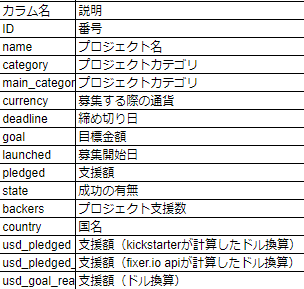

### 1.データセットの読み込みと確認

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数


df_csv = pd.read_csv(
    r"C:\Users\progr\OneDrive\kaggle\ks-projects-201801.csv")
df_csv.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [2]:
#データの情報収集　欠損値がないか確認する
display(df_csv.info())
display(df_csv.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


None

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [3]:
#続いて目的変数として不要なID、結果として得られるカラムを削除する
# "deadline", "launched" は、前処理の段階で扱うので、残しておく
df_csv = df_csv.drop(columns=["ID","pledged","usd pledged","usd_pledged_real","backers"])
df_csv.head()


,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,US,19500.00


In [4]:
#欠損している場所が僅かなので今回は削除する
df_csv = df_csv.dropna()
df_csv.isnull().sum()

name             0
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

In [5]:
#データの情報収集　欠損値がないか確認する
display(df_csv.info())
display(df_csv.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378657 entries, 0 to 378660
Data columns (total 10 columns):
name             378657 non-null object
category         378657 non-null object
main_category    378657 non-null object
currency         378657 non-null object
deadline         378657 non-null object
goal             378657 non-null float64
launched         378657 non-null object
state            378657 non-null object
country          378657 non-null object
usd_goal_real    378657 non-null float64
dtypes: float64(2), object(8)
memory usage: 31.8+ MB


None

name             0
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

----------------
### 2.データの可視化

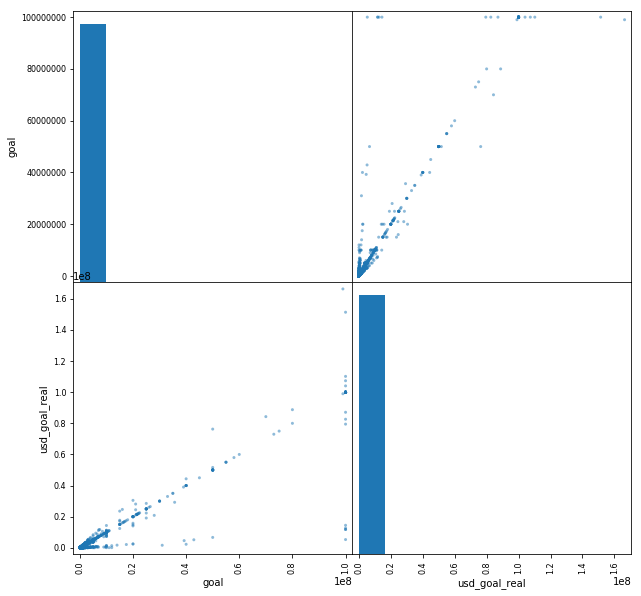

In [6]:
# 散布図行列を書いてみる
pd.plotting.scatter_matrix(df_csv, figsize=(10,10))
plt.show()

これだけでは、どれを説明変数として使ったらよいか分からないので、詳しく可視化を試みる

----------------
##### 2.データの可視化 - 国別
国別で成功、失敗の偏りが無いか確認してみる

In [7]:
#stateの中に何が含まれるか確認する
df_csv["state"].value_counts()

failed        197716
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64

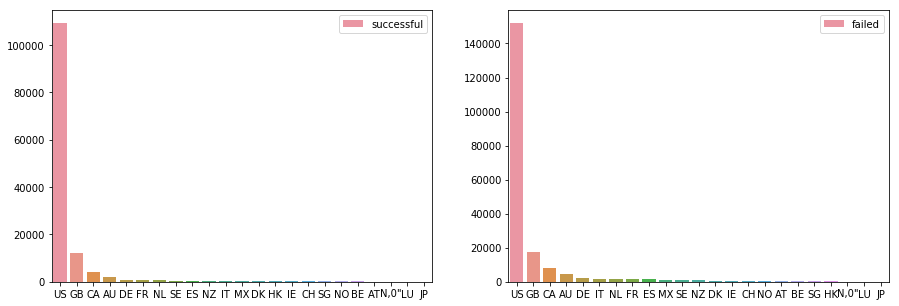

In [8]:
#国によって成功,失敗が異なるか見てみる
succ_country = df_csv[df_csv["state"]=="successful"]["country"].value_counts()
fali_country = df_csv[df_csv["state"]=="failed"]["country"].value_counts()

fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.barplot(succ_country.keys(), succ_country.values,ax=ax[0],label="successful")
sns.barplot(fali_country.keys(), fali_country.values,ax=ax[1],label="failed")
ax[0].legend()
ax[1].legend()

成功、失敗は国によって関係ありそうだが、そもそもUSのデータが多い可能性もあるため、国のデータの数も調べてみる

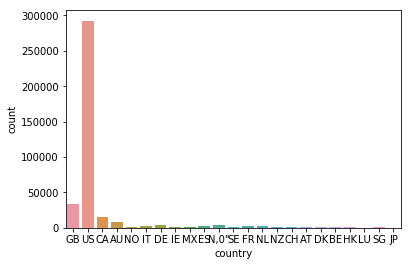

In [9]:
#国ごとのデータの数を可視化してみる
sns.countplot(df_csv["country"])

やはりデータの数は成功、失敗の数に関係しそうだが上位4ヵ国以降はデータの数にさほどバラつきがないため説明変数として有効であると考えられる

----------------
##### 2.データの可視化 - 期間
クラウドファンディングの募集期間が成功、失敗に関係していないか見てみる

In [10]:
#始まりの日時と終わりの日時を用いてクラウドファンディングが行われた期間を求める

df_csv["deadline"] = pd.to_datetime(df_csv["deadline"], errors="coerce")
df_csv["launched"] = pd.to_datetime(df_csv["launched"], errors="coerce")
df_csv["day"] = (df_csv["deadline"] - df_csv["launched"]).dt.days
df_csv["day"].head()

0    58
1    59
2    44
3    29
4    55
Name: day, dtype: int64

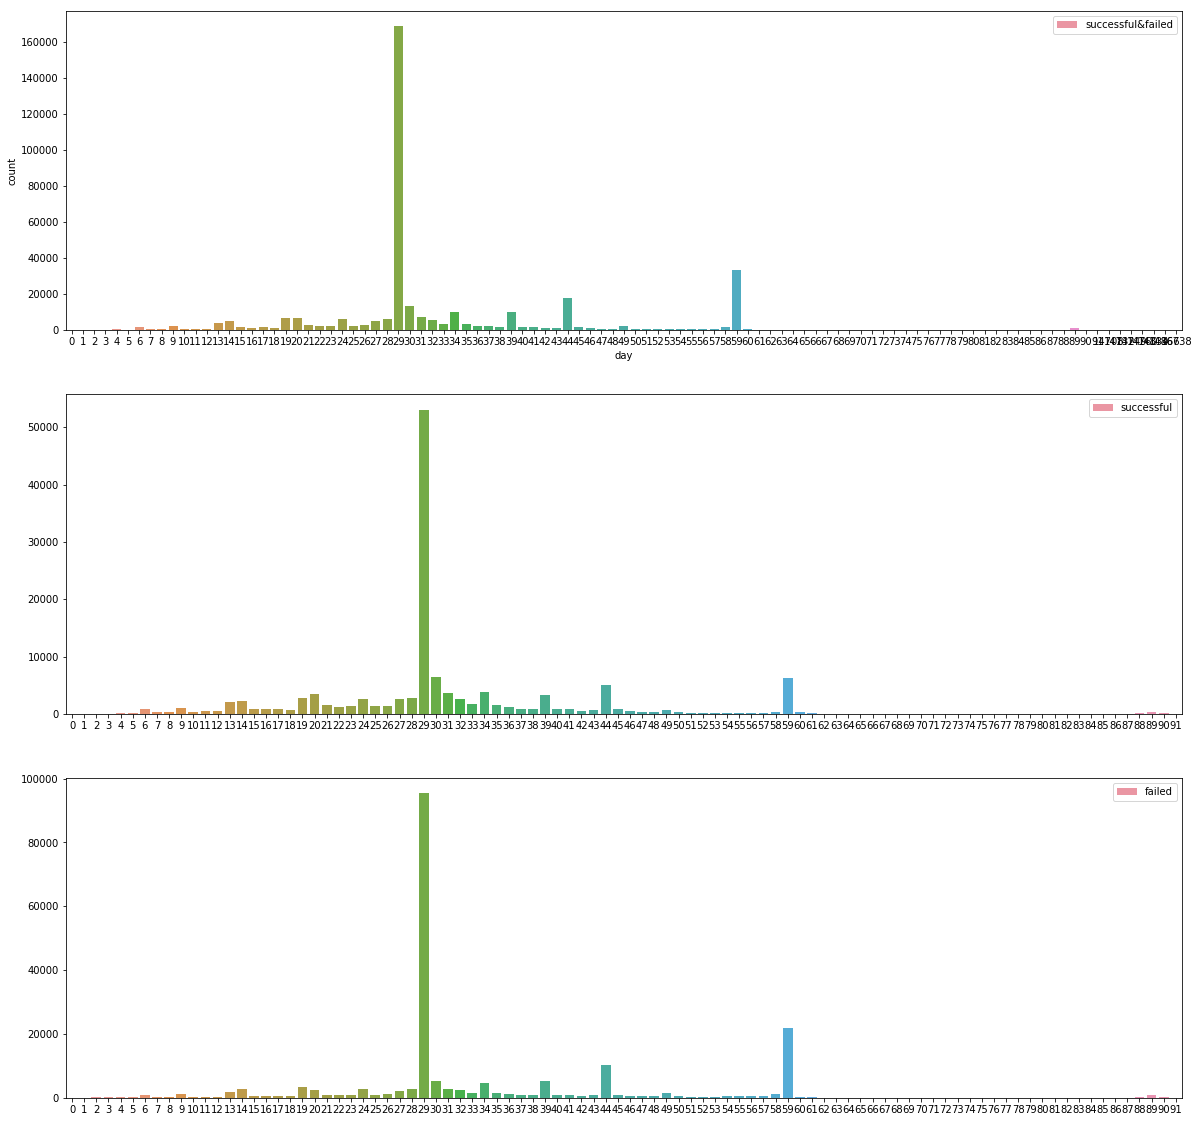

In [11]:
fig,ax = plt.subplots(3,1,figsize=(20,20))

#期間の散らばりを可視化する
sns.countplot(df_csv["day"],ax=ax[0],label="successful&failed")

#期間別に成功、失敗の偏りがないか可視化する
succ_day = df_csv[df_csv["state"]=="successful"]["day"].value_counts()
fali_day = df_csv[df_csv["state"]=="failed"]["day"].value_counts()

sns.barplot(succ_day.keys(), succ_day.values,ax=ax[1],label="successful")
sns.barplot(fali_day.keys(), fali_day.values,ax=ax[2],label="failed")
ax[0].legend()
ax[1].legend()
ax[2].legend()

総数が大きいのでこれだけでは明確には判断できない

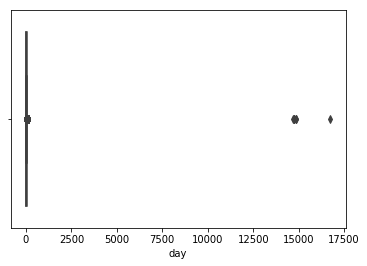

In [12]:
#外れ値を確認する
sns.boxplot(df_csv["day"])

大きな外れ値がある事が確認できるため、前処理の段階でどのような処理を施すか決める

----------------
##### 2.データの可視化 - カテゴリー別
カテゴリー別で成功、失敗の偏りが無いか確認してみる

In [13]:
#カテゴリに具体的にどのようなものが含まれるか確認する
df_csv["category"].value_counts()

Product Design       22313
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11829
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5187
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces            238
M

In [14]:
#メインカテゴリに具体的にどのようなものが含まれるか確認する
df_csv["main_category"].value_counts()

Film & Video    63584
Music           51918
Publishing      39874
Games           35230
Technology      32569
Design          30069
Art             28152
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

今回はメインカテゴリに関して調べてみる

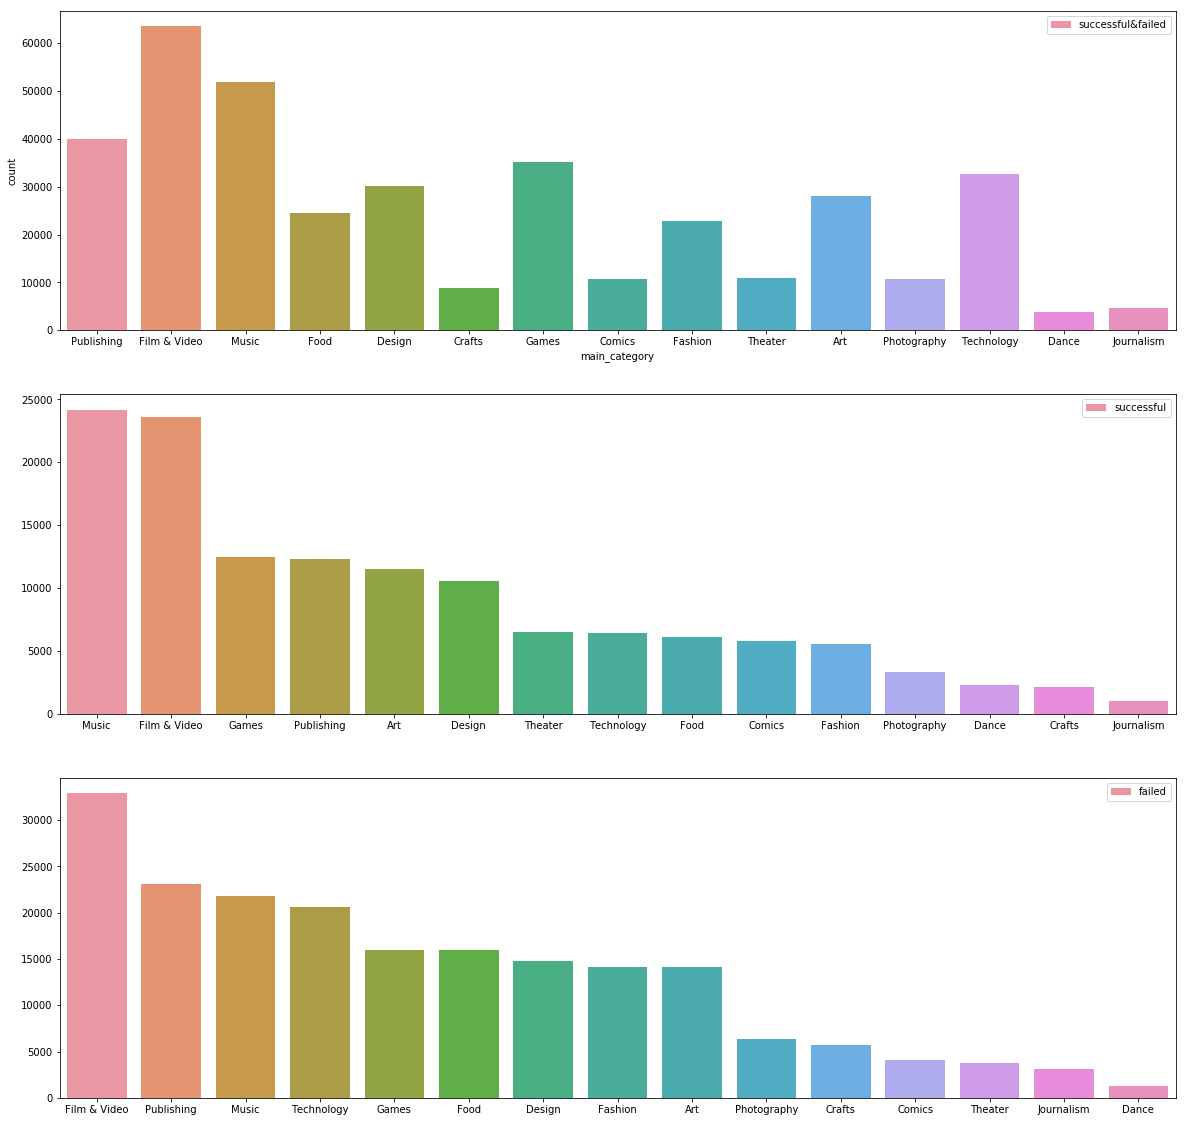

In [15]:
fig,ax = plt.subplots(3,1,figsize=(20,20))

#期間の散らばりを可視化する
sns.countplot(df_csv["main_category"],ax=ax[0],label="successful&failed")

#期間別に成功、失敗の偏りがないか可視化する
succ_main_cate = df_csv[df_csv["state"]=="successful"]["main_category"].value_counts()
fali_main_cate = df_csv[df_csv["state"]=="failed"]["main_category"].value_counts()
sns.barplot(succ_main_cate.keys(), succ_main_cate.values,ax=ax[1],label="successful")
sns.barplot(fali_main_cate.keys(), fali_main_cate.values,ax=ax[2],label="failed")
ax[0].legend()
ax[1].legend()
ax[2].legend()

カテゴリ別に成功失敗は大いに関係がありそうに考えられる

----------------
##### 2.データの可視化 - 目標金額別
目標金額別で成功、失敗の偏りが無いか確認してみる

In [16]:
#メインカテゴリに具体的にどのようなものが含まれるか確認する
df_csv["goal"].value_counts()

5000.0       29779
10000.0      26029
1000.0       16950
3000.0       15743
2000.0       15256
15000.0      14231
20000.0      13104
2500.0       11863
500.0        11599
25000.0      10371
1500.0       10314
50000.0       9571
4000.0        8310
30000.0       7782
6000.0        7496
3500.0        6791
8000.0        6479
7000.0        5076
12000.0       4987
100000.0      4862
7500.0        4814
35000.0       3592
40000.0       3428
300.0         3196
1200.0        3031
4500.0        2912
5500.0        2835
600.0         2807
800.0         2522
100.0         2458
             ...  
10922.0          1
2988.0           1
765000.0         1
2095.0           1
11956.0          1
49680.0          1
15420.0          1
1894.0           1
7578.0           1
5965.0           1
4700000.0        1
21950.0          1
7577.0           1
2977.0           1
47633.0          1
47645.0          1
2978.0           1
6432.0           1
15153.0          1
1489.5           1
47666.0          1
5959.0      

ここで、"goal"の情報を出しバラつきを確認する

In [17]:
df_csv["goal"].describe()

count    3.786570e+05
mean     4.908068e+04
std      1.183397e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.200000e+03
75%      1.600000e+04
max      1.000000e+08
Name: goal, dtype: float64

分散が大きい事から、前処理の段階で標準化を行う

----
### 3.前処理
データの削除と離散数値の変換

In [18]:
#成功、失敗の他に結果として何があるか再度確認する
df_csv["state"].value_counts()

failed        197716
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64

In [19]:
#今回は成功と失敗の数が9割を占めているので他は削除する
df_csv_success = df_csv[df_csv["state"]=="successful"]
df_csv_failed = df_csv[df_csv["state"]=="failed"]
df_csv = pd.concat([df_csv_success, df_csv_failed])

#データを扱いやすくするため成功を１失敗を０に置き換える
df_csv["state"] = df_csv["state"].replace("failed",0)
df_csv["state"] = df_csv["state"].replace("successful",1)

In [20]:
#分類器にかける前に文字データを離散の数値に変換しておく

le = LabelEncoder()


le.fit( df_csv["name"])
df_csv["name"] = le.transform(df_csv["name"])

le.fit(df_csv["category"])
df_csv["category"] = le.transform(df_csv["category"])

le.fit(df_csv["main_category"])
df_csv["main_category"] = le.transform(df_csv["main_category"])

le.fit(df_csv["currency"])
df_csv["currency"] = le.transform(df_csv["currency"])

le.fit(df_csv["country"])
df_csv["country"] = le.transform(df_csv["country"])

In [21]:
#全て離散の数値に変換されたことを確認する
df_csv.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,day
5,177276,123,7,13,2016-04-01,50000.0,2016-02-26 13:38:27,1,22,50000.00,34
6,251826,58,7,13,2014-12-21,1000.0,2014-12-01 18:30:44,1,22,1000.00,19
11,160220,72,10,13,2013-04-08,12500.0,2013-03-09 06:42:58,1,22,12500.00,29
14,296505,136,8,5,2017-05-03,5000.0,2017-04-05 19:44:18,1,9,6469.73,27
18,174638,90,10,13,2012-08-17,250.0,2012-08-02 14:11:32,1,22,250.00,14


In [22]:
#"deadline","launched"は不要なので削除する
df_csv = df_csv.drop(columns=["deadline","launched"])
df_csv.head()

,name,category,main_category,currency,goal,state,country,usd_goal_real,day
5,177276,123,7,13,50000.0,1,22,50000.00,34
6,251826,58,7,13,1000.0,1,22,1000.00,19
11,160220,72,10,13,12500.0,1,22,12500.00,29
14,296505,136,8,5,5000.0,1,9,6469.73,27
18,174638,90,10,13,250.0,1,22,250.00,14


In [23]:
df_csv.describe()

,name,category,main_category,currency,goal,state,country,usd_goal_real,day
count,331672.000000,331672.000000,331672.000000,331672.000000,3.316720e+05,331672.000000,331672.000000,3.316720e+05,331672.000000
mean,164858.566822,80.292268,7.483435,11.081234,4.425126e+04,0.403881,18.994838,4.150966e+04,32.954889
std,95115.382234,45.069070,3.931462,3.878572,1.117922e+06,0.490675,6.193820,1.108935e+06,12.713279
min,0.000000,0.000000,0.000000,0.000000,1.000000e-02,0.000000,0.000000,1.000000e-02,0.000000
25%,82481.750000,39.000000,5.000000,13.000000,2.000000e+03,0.000000,22.000000,2.000000e+03,29.000000
50%,164897.500000,85.000000,7.000000,13.000000,5.000000e+03,0.000000,22.000000,5.000000e+03,29.000000
75%,247272.250000,119.000000,10.000000,13.000000,1.500000e+04,1.000000,22.000000,1.500000e+04,35.000000
max,329593.000000,158.000000,14.000000,13.000000,1.000000e+08,1.000000,22.000000,1.663614e+08,91.000000


現段階では、分散が大きい項目について標準化するとテストデータに関しても影響が出てしまうので学習の前段階で行う

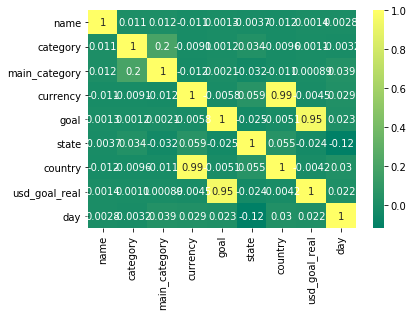

In [24]:
#相関係数を見る
sns.heatmap(df_csv.corr(),cmap="summer",annot=True)
plt.show()

"goal"と"usd_goal_real"は強い正の相関が見られるため今回は"goal"のみを使用する
"country"と"currency"にも強い正の相関が見られるので"country"を使用する

In [25]:
df_csv1 = df_csv.drop(columns=["currency","usd_goal_real"])
df_csv1.head()

,name,category,main_category,goal,state,country,day
5,177276,123,7,50000.0,1,22,34
6,251826,58,7,1000.0,1,22,19
11,160220,72,10,12500.0,1,22,29
14,296505,136,8,5000.0,1,9,27
18,174638,90,10,250.0,1,22,14


今回はこちらのデータを説明変数として予測していく

----
### 4.データを標準化して分類器にかける

In [26]:
#目的変数を"state", 説明変数を"category", "main_category", "name" "goal", "country", "day"
y = df_csv1["state"].values
x = df_csv1.drop(columns=["state"]).values

#学習を上手く行うために平均０, 分散１になるように正規化する（標準化）
std_scaler = StandardScaler()

# fit_transform関数で標準化した特徴量X_scaledを得る
# 以降はX_scaledをモデルの学習等に使う
x_scaled = std_scaler.fit_transform(x)
clf = SGDClassifier(
    loss="log", penalty="none", max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3
)
clf.fit(x_scaled,y)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [27]:
# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0,0]
w2 = clf.coef_[0,1]
w3 = clf.coef_[0,2]
w4 = clf.coef_[0,3]
w5 = clf.coef_[0,4]
w6 = clf.coef_[0,5]


print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

w0 = -0.809, w1 = -0.031, w2 = 0.146, w3 = -0.030, w4 = -16.705, w5 = 0.098, w6 = -0.206


In [28]:
# ラベルを予測
y_est = clf.predict(x_scaled)
# 確率値を得る
y_est_proba = clf.predict_proba(x_scaled)
#対数尤度を表示
print("対数尤度 = {:.3f}".format(-log_loss(y, y_est_proba, normalize=False)))

対数尤度 = -215257.959


In [29]:
#混同行列を作成 
tn, fp, fn, tp = confusion_matrix(y, y_est).ravel() 

print('Accuracy = {:.3f}%'.format(100 * (tn+tp)/(tn+fp+fn+tp))) 
print('Recall = {:.3f}%'.format(100 * (tp)/(fn+tp))) 
print('Precision = {:.3f}%'.format(100 * (tp)/(fp+tp)))

Accuracy = 61.289%
Recall = 24.393%
Precision = 54.652%


In [30]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est),
                       index=["正解 = クラウドファンディング成功","正解 = クラウドファンディング失敗"],
                       columns=["予測 = クラウドファンディング成功", "予測 = クラウドファンディング失敗"])
conf_mat

,予測 = クラウドファンディング成功,予測 = クラウドファンディング失敗
正解 = クラウドファンディング成功,170603,27113
正解 = クラウドファンディング失敗,101280,32676


まだまだ改善の余地はありそうだ。

----
### 5.ホールドアウト法

ここでは学習用のデータ、テスト用のデータに分けて学習をし、汎化誤差を出す

In [31]:
from sklearn.model_selection import train_test_split
test_size = 0.3
#学習用データ、テスト用データに分割する
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

In [32]:
#標準化をする
X_tr_sc = std_scaler.fit_transform(X_train)
X_te_sc = std_scaler.transform(X_test)

In [33]:
#分類器にかける
clf = SGDClassifier(
    loss="log", penalty="none", max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3
)
clf.fit(X_tr_sc, y_train)
y_pred = clf.predict(X_te_sc)

#混合行列を作成
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
print('Accuracy = {:.3f}%'.format(100 * (tn+tp)/(tn+fp+fn+tp))) 
print('Recall = {:.3f}%'.format(100 * (tp)/(fn+tp))) 
print('Precision = {:.3f}%'.format(100 * (tp)/(fp+tp)))



Accuracy = 60.804%
Recall = 12.940%
Precision = 56.794%


精度は向上したが、学習用データ、テスト用データに偏りがある可能性があるため、分割してそれぞれ対して学習、予測を行う

,予測 = クラウドファンディング成功,予測 = クラウドファンディング失敗
正解 = クラウドファンディング成功,55293,3962
正解 = クラウドファンディング失敗,35039,5208


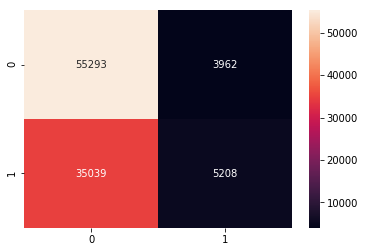

In [34]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred),
                       index=["正解 = クラウドファンディング成功","正解 = クラウドファンディング失敗"],
                       columns=["予測 = クラウドファンディング成功", "予測 = クラウドファンディング失敗"])
display(conf_mat)
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt='d')
plt.show()

----
### 6.クロスバリデーション

ここでは学習用データ、テスト用データの分割によって予測の偏りをなくすため5分割してそれぞれに対して予測を行う

In [31]:
# 分割数n_splits, ランダム性の固定を行うrandom_state, データのシャッフルを行うかを指定するshuffleを引数に与える
n_split = 5 
kf=KFold(n_splits=n_split, random_state=1234, shuffle=True)


split_num = 1
acc = 0
rec = 0
pre = 0
# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in kf.split(x, y):
    X_train, y_train = x[train_idx], y[train_idx] #学習用データ
    X_test, y_test = x[test_idx], y[test_idx]  #テスト用データ
    
    #標準化をする
    X_tr_sc = std_scaler.fit_transform(X_train)
    X_te_sc = std_scaler.transform(X_test)
    
    # 学習用データを使って線形回帰モデルを学習
    clf.fit(X_tr_sc,y_train)
    
    #混合行列を作成
    y_pred = clf.predict(X_te_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
    recall = 100 * (tp)/(fn+tp)
    precision = 100 * (tp)/(fp+tp)
    
    #クロスバリデーションの結果を算出
    print("Fold %s"%split_num)
    print('Accuracy = {:.3f}%'.format(accuracy)) 
    print('Recall = {:.3f}%'.format(recall)) 
    print('Precision = {:.3f}%'.format(precision))
    print()

    acc += accuracy
    rec += recall
    pre += precision
    split_num +=1

final_acc = acc / n_split
final_rec = rec / n_split
final_pre = pre / n_split
print('平均 Accuracy = {:.3f}%'.format(final_acc))
print('平均 Recall = {:.3f}%'.format(final_rec))
print('平均 Precision = {:.3f}%'.format(final_pre))
    
    

Fold 1
Accuracy = 61.244%
Recall = 17.863%
Precision = 55.012%

Fold 2
Accuracy = 60.380%
Recall = 8.068%
Precision = 58.072%

Fold 3
Accuracy = 60.361%
Recall = 23.707%
Precision = 52.757%

Fold 4
Accuracy = 61.204%
Recall = 24.630%
Precision = 54.954%

Fold 5
Accuracy = 61.759%
Recall = 22.042%
Precision = 55.896%

平均 Accuracy = 60.989%
平均 Recall = 19.262%
平均 Precision = 55.338%


学習用データ、テストデータに偏りが低い精度が求められた

----
### 6.無相関化
ここでは前処理の段階で説明変数どうしに強い正の相関が見られた変数を新たに説明変数として加え、無相関をして精度向上を試みる

,name,category,main_category,currency,goal,state,country,usd_goal_real,day
5,177276,123,7,13,50000.0,1,22,50000.00,34
6,251826,58,7,13,1000.0,1,22,1000.00,19
11,160220,72,10,13,12500.0,1,22,12500.00,29
14,296505,136,8,5,5000.0,1,9,6469.73,27
18,174638,90,10,13,250.0,1,22,250.00,14


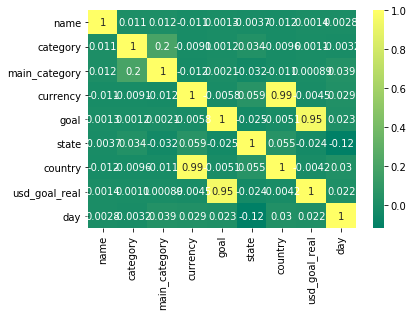

In [35]:
display(df_csv.head())
sns.heatmap(df_csv.corr(),cmap="summer",annot=True)
plt.show()

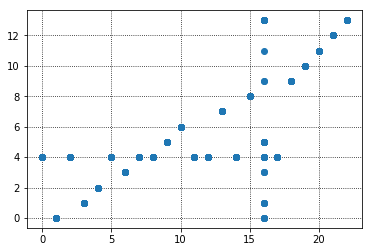

In [36]:
#無相関化を行うためにデータを抽出する
s = df_csv.loc[:,["country","currency"]]
data1 = s.values.tolist()
data1 = np.array(data1)
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(data1[:, 0], data1[:, 1], 'o')
plt.show()

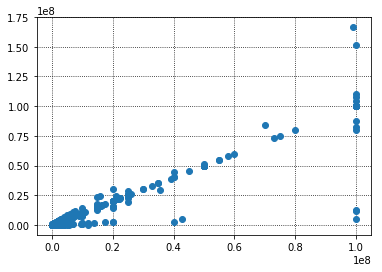

In [37]:
v = df_csv.loc[:,["goal","usd_goal_real"]]
data2 = v.values.tolist()
data2 = np.array(data2)
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(data2[:, 0], data2[:, 1], 'o')
plt.show()

In [38]:
# 分割数n_splits, ランダム性の固定を行うrandom_state, データのシャッフルを行うかを指定するshuffleを引数に与える
n_split = 5 
kf=KFold(n_splits=n_split, random_state=1234, shuffle=True)


split_num = 1
acc = 0
rec = 0
pre = 0
# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in kf.split(x, y):
    X_train, y_train = x[train_idx], y[train_idx] #学習用データ
    X_test, y_test = x[test_idx], y[test_idx]  #テスト用データ
    
    #標準化をする
    X_tr_sc = std_scaler.fit_transform(X_train)
    X_te_sc = std_scaler.transform(X_test)
    
    # 学習用データを使って線形回帰モデルを学習
    clf.fit(X_tr_sc,y_train)
    
    #混合行列を作成
    y_pred = clf.predict(X_te_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
    recall = 100 * (tp)/(fn+tp)
    precision = 100 * (tp)/(fp+tp)
    
    #クロスバリデーションの結果を算出
    print("Fold %s"%split_num)
    print('Accuracy = {:.3f}%'.format(accuracy)) 
    print('Recall = {:.3f}%'.format(recall)) 
    print('Precision = {:.3f}%'.format(precision))
    print()

    acc += accuracy
    rec += recall
    pre += precision
    split_num +=1

final_acc = acc / n_split
final_rec = rec / n_split
final_pre = pre / n_split
print('平均 Accuracy = {:.3f}%'.format(final_acc))
print('平均 Recall = {:.3f}%'.format(final_rec))
print('平均 Precision = {:.3f}%'.format(final_pre))
    
    

Fold 1
Accuracy = 61.244%
Recall = 17.863%
Precision = 55.012%

Fold 2
Accuracy = 60.380%
Recall = 8.068%
Precision = 58.072%

Fold 3
Accuracy = 60.361%
Recall = 23.707%
Precision = 52.757%

Fold 4
Accuracy = 61.204%
Recall = 24.630%
Precision = 54.954%

Fold 5
Accuracy = 61.759%
Recall = 22.042%
Precision = 55.896%

平均 Accuracy = 60.989%
平均 Recall = 19.262%
平均 Precision = 55.338%


相関係数: 0.000


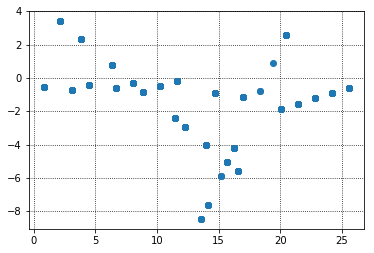

In [39]:
#  無相関化を行うための一連の処理
cov1 = np.cov(data1, rowvar=0) # 分散・共分散を求める
_, S = np.linalg.eig(cov1)           # 分散共分散行列の固有ベクトルを用いて
data1_decorr = np.dot(S.T, data1.T).T #データを無相関化

#無相関化の結果を表示する
print('相関係数: {:.3f}'.format(np.corrcoef(data1_decorr[:, 0], data1_decorr[:, 1])[0,1]))
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(data1_decorr[:, 0], data1_decorr[:, 1], 'o')
plt.show()

相関係数: -0.000


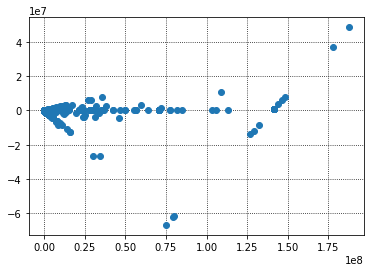

In [40]:
#  無相関化を行うための一連の処理
cov2 = np.cov(data2, rowvar=0) # 分散・共分散を求める
_, S = np.linalg.eig(cov2)           # 分散共分散行列の固有ベクトルを用いて
data2_decorr = np.dot(S.T, data2.T).T #データを無相関化

#無相関化の結果を表示する
print('相関係数: {:.3f}'.format(np.corrcoef(data2_decorr[:, 0], data2_decorr[:, 1])[0,1]))
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(data2_decorr[:, 0], data2_decorr[:, 1], 'o')
plt.show()

In [41]:
#元のデータと置き換える

df_csv[["country","currency"]] = data1_decorr 
df_csv[["goal","usd_goal_real"]] = data2_decorr

df_csv.head()

,name,category,main_category,currency,goal,state,country,usd_goal_real,day
5,177276,123,7,-0.586333,70710.043568,1,25.547137,299.563928,34
6,251826,58,7,-0.586333,1414.200871,1,25.547137,5.991279,19
11,160220,72,10,-0.586333,17677.510892,1,25.547137,74.890982,29
14,296505,136,8,-0.510009,8105.848299,1,10.282990,1073.605897,27
18,174638,90,10,-0.586333,353.550218,1,25.547137,1.497820,14


In [42]:
y = df_csv["state"].values
x = df_csv.drop(columns=["state"]).values

# 分割数n_splits, ランダム性の固定を行うrandom_state, データのシャッフルを行うかを指定するshuffleを引数に与える
n_split = 5 
kf=KFold(n_splits=n_split, random_state=1234, shuffle=True)

split_num = 1
acc = 0
rec = 0
pre = 0

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in kf.split(x, y):
    X_train, y_train = x[train_idx], y[train_idx] #学習用データ
    X_test, y_test = x[test_idx], y[test_idx]  #テスト用データ
    
    #標準化をする
    X_tr_sc = std_scaler.fit_transform(X_train)
    X_te_sc = std_scaler.transform(X_test)
    
    # 学習用データを使って線形回帰モデルを学習
    clf.fit(X_tr_sc,y_train)
    
    #クロスバリデーションの結果を算出
    y_pred = clf.predict(X_te_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
    recall = 100 * (tp)/(fn+tp)
    precision = 100 * (tp)/(fp+tp)
    print("Fold %s"%split_num)
    print('Accuracy = {:.3f}%'.format(accuracy)) 
    print('Recall = {:.3f}%'.format(recall)) 
    print('Precision = {:.3f}%'.format(precision))
    print()

    acc += accuracy
    rec += recall
    pre += precision
    split_num +=1

final_acc = acc / n_split
final_rec = rec / n_split
final_pre = pre / n_split
print('平均 Accuracy = {:.3f}%'.format(final_acc))
print('平均 Recall = {:.3f}%'.format(final_rec))
print('平均 Precision = {:.3f}%'.format(final_pre))
    
    

Fold 1
Accuracy = 61.699%
Recall = 27.030%
Precision = 54.421%

Fold 2
Accuracy = 60.626%
Recall = 10.351%
Precision = 57.979%

Fold 3
Accuracy = 60.453%
Recall = 26.790%
Precision = 52.657%

Fold 4
Accuracy = 61.183%
Recall = 28.027%
Precision = 54.248%

Fold 5
Accuracy = 61.552%
Recall = 27.695%
Precision = 54.033%

平均 Accuracy = 61.103%
平均 Recall = 23.979%
平均 Precision = 54.668%


----
### 6.L1正則化・L2正則化

In [43]:
# L1正則化から行う
# penaltyをL1,L2にする事で正則化を行える
clf = SGDClassifier(
    loss="log", penalty="l1", max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3
)

In [44]:
# 分割数n_splits, ランダム性の固定を行うrandom_state, データのシャッフルを行うかを指定するshuffleを引数に与える
n_split = 5 
kf=KFold(n_splits=n_split, random_state=1234, shuffle=True)

split_num = 1
acc = 0
rec = 0
pre = 0
# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in kf.split(x, y):
    X_train, y_train = x[train_idx], y[train_idx] #学習用データ
    X_test, y_test = x[test_idx], y[test_idx]  #テスト用データ
    
    #標準化をする
    X_tr_sc = std_scaler.fit_transform(X_train)
    X_te_sc = std_scaler.transform(X_test)
    
    # 学習用データを使って線形回帰モデルを学習
    clf.fit(X_tr_sc,y_train)
    
   #クロスバリデーションの結果を算出
    y_pred = clf.predict(X_te_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
    recall = 100 * (tp)/(fn+tp)
    precision = 100 * (tp)/(fp+tp)
    print("Fold %s"%split_num)
    print('Accuracy = {:.3f}%'.format(accuracy)) 
    print('Recall = {:.3f}%'.format(recall)) 
    print('Precision = {:.3f}%'.format(precision))
    print()

    acc += accuracy
    rec += recall
    pre += precision
    split_num +=1

final_acc = acc / n_split
final_rec = rec / n_split
final_pre = pre / n_split
print('平均 Accuracy = {:.3f}%'.format(final_acc))
print('平均 Recall = {:.3f}%'.format(final_rec))
print('平均 Precision = {:.3f}%'.format(final_pre))
    

Fold 1
Accuracy = 61.241%
Recall = 13.235%
Precision = 56.992%

Fold 2
Accuracy = 60.504%
Recall = 8.819%
Precision = 58.442%

Fold 3
Accuracy = 60.039%
Recall = 8.527%
Precision = 55.478%

Fold 4
Accuracy = 61.123%
Recall = 25.524%
Precision = 54.530%

Fold 5
Accuracy = 61.747%
Recall = 22.854%
Precision = 55.622%

平均 Accuracy = 60.930%
平均 Recall = 15.792%
平均 Precision = 56.213%


続いてL2正則化も試してみる

In [45]:
# L2正則化
clf = SGDClassifier(
    loss="log", penalty="l2", max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3
)

In [46]:
# 分割数n_splits, ランダム性の固定を行うrandom_state, データのシャッフルを行うかを指定するshuffleを引数に与える
n_split = 5 
kf=KFold(n_splits=n_split, random_state=1234, shuffle=True)

acc = 0
rec = 0
pre = 0
split_num = 1
# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in kf.split(x, y):
    X_train, y_train = x[train_idx], y[train_idx] #学習用データ
    X_test, y_test = x[test_idx], y[test_idx]  #テスト用データ
    
    #標準化をする
    X_tr_sc = std_scaler.fit_transform(X_train)
    X_te_sc = std_scaler.transform(X_test)
    
    # 学習用データを使って線形回帰モデルを学習
    clf.fit(X_tr_sc,y_train)
    
    # テストデータに対する予測を実行
    pred = clf.score(X_te_sc,y_test)
    
    #クロスバリデーションの結果を算出
    y_pred = clf.predict(X_te_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
    recall = 100 * (tp)/(fn+tp)
    precision = 100 * (tp)/(fp+tp)
    print("Fold %s"%split_num)
    print('Accuracy = {:.3f}%'.format(accuracy)) 
    print('Recall = {:.3f}%'.format(recall)) 
    print('Precision = {:.3f}%'.format(precision))
    print()

    acc += accuracy
    rec += recall
    pre += precision
    split_num +=1

final_acc = acc / n_split
final_rec = rec / n_split
final_pre = pre / n_split
print('平均 Accuracy = {:.3f}%'.format(final_acc))
print('平均 Recall = {:.3f}%'.format(final_rec))
print('平均 Precision = {:.3f}%'.format(final_pre))
    
    

Fold 1
Accuracy = 61.135%
Recall = 16.204%
Precision = 55.071%

Fold 2
Accuracy = 59.940%
Recall = 5.419%
Precision = 55.974%

Fold 3
Accuracy = 60.082%
Recall = 18.860%
Precision = 52.493%

Fold 4
Accuracy = 60.718%
Recall = 19.041%
Precision = 54.658%

Fold 5
Accuracy = 61.049%
Recall = 14.761%
Precision = 55.403%

平均 Accuracy = 60.585%
平均 Recall = 14.857%
平均 Precision = 54.720%


続いてハイパーパラメータチューニングを行っていく

In [47]:
from sklearn.model_selection import GridSearchCV
param = {"penalty":["l1","l2"], "alpha":[0.0001,0.001,0.01,0.1]}
model =  SGDClassifier(
    loss="log",fit_intercept=True, random_state=1234, max_iter=10000, tol=1e-3
)
clf = GridSearchCV(model,param,cv=5)
clf.fit(X_tr_sc,y_train)
print(clf.best_params_, clf.best_score_)

{'alpha': 0.0001, 'penalty': 'l1'} 0.608156389209235


チューニングしたハイパーパラメータを用いて交差検証法を行う

In [48]:
clf2 = SGDClassifier(**clf.best_params_,loss="log" ,fit_intercept=True, random_state=1234, max_iter=10000, tol=1e-3)

# 分割数n_splits, ランダム性の固定を行うrandom_state, データのシャッフルを行うかを指定するshuffleを引数に与える
n_split = 5 

kf=KFold(n_splits=n_split, random_state=1234, shuffle=True)

acc = 0
rec = 0
pre = 0
split_num = 1
# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in kf.split(x, y):
    X_train, y_train = x[train_idx], y[train_idx] #学習用データ
    X_test, y_test = x[test_idx], y[test_idx]  #テスト用データ
    
    #標準化をする
    X_tr_sc = std_scaler.fit_transform(X_train)
    X_te_sc = std_scaler.transform(X_test)
    
    # 学習用データを使って線形回帰モデルを学習
    clf2.fit(X_tr_sc,y_train)
    
    #クロスバリデーションの結果を算出
    #混同行列を作成 
    y_pred = clf.predict(X_te_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
    recall = 100 * (tp)/(fn+tp)
    precision = 100 * (tp)/(fp+tp)
    print("Fold %s"%split_num)
    print('Accuracy = {:.3f}%'.format(accuracy)) 
    print('Recall = {:.3f}%'.format(recall)) 
    print('Precision = {:.3f}%'.format(precision))
    print()

    acc += accuracy
    rec += recall
    pre += precision
    split_num +=1

final_acc = acc / n_split
final_rec = rec / n_split
final_pre = pre / n_split
print('平均 Accuracy = {:.3f}%'.format(final_acc))
print('平均 Recall = {:.3f}%'.format(final_rec))
print('平均 Precision = {:.3f}%'.format(final_pre))
    
    

Fold 1
Accuracy = 61.880%
Recall = 24.637%
Precision = 55.450%

Fold 2
Accuracy = 61.265%
Recall = 21.227%
Precision = 55.820%

Fold 3
Accuracy = 61.269%
Recall = 22.999%
Precision = 55.704%

Fold 4
Accuracy = 61.306%
Recall = 21.800%
Precision = 56.032%

Fold 5
Accuracy = 61.747%
Recall = 22.854%
Precision = 55.622%

平均 Accuracy = 61.493%
平均 Recall = 22.703%
平均 Precision = 55.725%


わずかに精度の向上が見られた

次は特徴量選択を行う

----
### 7.特徴量抽出

LASSOによる特徴選択

In [49]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel


#ここでもう一度目的変数と説明変数を改めて定義し直す
#無相関化したデータを用いる
y = df_csv["state"].values
x = df_csv.drop(columns=["state"]).values

#学習用データ、テストデータに分割する
test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

#それぞれを標準化する
X_tr_sc = std_scaler.fit_transform(X_train)
X_te_sc = std_scaler.transform(X_test)

#特徴量を抽出する
# estimatorにモデルセット
# LassoCVを使って、正則化の強さは自動設定
estimator = LassoCV(normalize=True, cv=10)
sfm = SelectFromModel(estimator, threshold=1e-5)
sfm.fit(X_tr_sc,y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

Lassoによって選択された特徴量を使用して、学習を行う

In [50]:
X_tr_lasso = sfm.transform(X_tr_sc)
X_te_lasso = sfm.transform(X_te_sc)

clf = SGDClassifier(
    loss="log", penalty="none", max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3
)

clf.fit(X_tr_lasso,y_train)
y_pred = clf.predict(X_te_lasso)

#混合行列を作成
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
print('Accuracy = {:.3f}%'.format(100 * (tn+tp)/(tn+fp+fn+tp))) 
print('Recall = {:.3f}%'.format(100 * (tp)/(fn+tp))) 
print('Precision = {:.3f}%'.format(100 * (tp)/(fp+tp)))



Accuracy = 61.275%
Recall = 19.949%
Precision = 56.109%


今までで一番精度の良いモデルが期待できそうなため、クロスバリデーションでより確実な精度を求める

In [51]:
#無相関化したデータを用いる
y = df_csv["state"].values
x = df_csv.drop(columns=["state"]).values

#モデルの定義
clf = SGDClassifier(
    loss="log", penalty="none", max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3
)

# 分割数n_splits, ランダム性の固定を行うrandom_state, データのシャッフルを行うかを指定するshuffleを引数に与える
n_split = 5 

kf=KFold(n_splits=n_split, random_state=1234, shuffle=True)

acc = 0
rec = 0
pre = 0
split_num = 1
# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in kf.split(x, y):
    X_train, y_train = x[train_idx], y[train_idx] #学習用データ
    X_test, y_test = x[test_idx], y[test_idx]  #テスト用データ
    
    #標準化をする
    X_tr_sc = std_scaler.fit_transform(X_train)
    X_te_sc = std_scaler.transform(X_test)
    
    #特徴量を抽出する
    # estimatorにモデルセット
    # LassoCVを使って、正則化の強さは自動設定
    estimator = LassoCV(normalize=True, cv=10)
    sfm = SelectFromModel(estimator, threshold=1e-5)
    sfm.fit(X_tr_sc,y_train)
    
    X_tr_lasso = sfm.transform(X_tr_sc)
    X_te_lasso = sfm.transform(X_te_sc)
    
    # 学習用データを使って線形回帰モデルを学習
    clf.fit(X_tr_lasso,y_train)
    
    #クロスバリデーションの結果を算出
    y_pred = clf.predict(X_te_lasso)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
    recall = 100 * (tp)/(fn+tp)
    precision = 100 * (tp)/(fp+tp)
    print("Fold %s"%split_num)
    print('Accuracy = {:.3f}%'.format(accuracy)) 
    print('Recall = {:.3f}%'.format(recall)) 
    print('Precision = {:.3f}%'.format(precision))
    print()

    acc += accuracy
    rec += recall
    pre += precision
    split_num +=1

final_acc = acc / n_split
final_rec = rec / n_split
final_pre = pre / n_split
print('平均 Accuracy = {:.3f}%'.format(final_acc))
print('平均 Recall = {:.3f}%'.format(final_rec))
print('平均 Precision = {:.3f}%'.format(final_pre))
    
    

Fold 1
Accuracy = 61.699%
Recall = 27.030%
Precision = 54.421%

Fold 2
Accuracy = 60.626%
Recall = 10.351%
Precision = 57.979%

Fold 3
Accuracy = 60.453%
Recall = 26.790%
Precision = 52.657%

Fold 4
Accuracy = 61.183%
Recall = 28.027%
Precision = 54.248%

Fold 5
Accuracy = 61.552%
Recall = 27.695%
Precision = 54.033%

平均 Accuracy = 61.103%
平均 Recall = 23.979%
平均 Precision = 54.668%


学習前に確認しなかった、必要な特徴を確認する

In [52]:
# Trueになっている特徴が学習に必要な特徴
sfm.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True])

やはりここでは特徴量が少ないため、削除する必要がなさそうだ

In [53]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([0.00104298, 0.02005412, 0.0163457 , 0.01243258, 0.01072718,
       0.028824  , 0.00191157, 0.05664956])

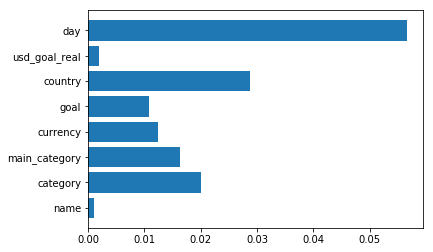

In [54]:
# 係数を棒グラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef,tick_label=df_csv.drop(columns=["state"]).columns.values)
plt.show()

比較的値が低い"name"を削除して学習を試みる

In [55]:
df_csv = df_csv.drop(columns=["name"],axis=1)

--------------
##### 今後の大まかな学習手順は、以下の通りに進める（学習方法によって最適な手段で進める）

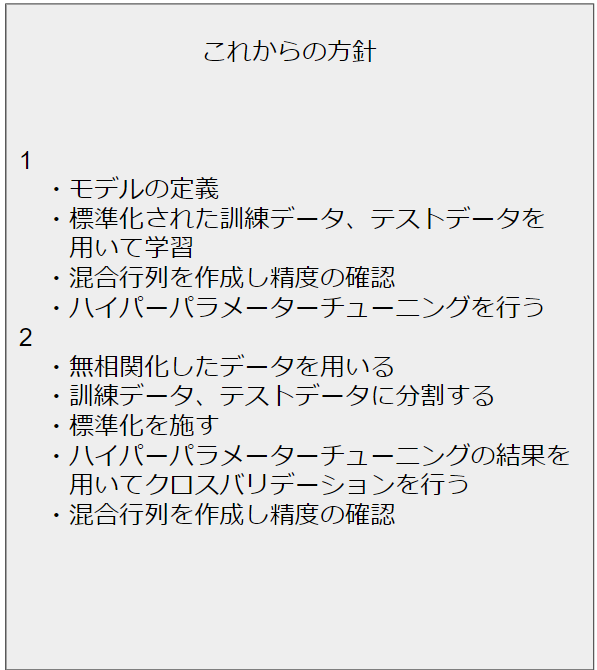

----
### 8.SVM (サポートベクターマシーン)

* ここで気を付けたいことは、説明変数が8個ありデータも大きいため、計算に時間がかかってしまう
* そのためLassoで特徴量を抽出したデータで学習を試みる
* 今までで線形回帰モデルで試してきたが精度の向上見られなかったため、非線形分離を行う。よってカーネルはRBFを用いる

In [56]:
y = df_csv1["state"].values
x = df_csv1.drop(columns=["state"]).values
test_size = 0.3
#学習用データ、テスト用データに分割する
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
#標準化をする
X_tr_sc = std_scaler.fit_transform(X_train)
X_te_sc = std_scaler.transform(X_test)

In [57]:
from sklearn.svm import SVC
# SVMの実行
C = 5
# 非線形モデルを使う
kernel = "rbf"
# 誤分類のどのくらい許容するかを決めるパラメータ
gamma = 1
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_tr_sc, y_train)
y_pred = clf.predict(X_te_sc)

#混合行列を作成
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
recall = 100 * (tp)/(fn+tp)
precision = 100 * (tp)/(fp+tp)
print('Accuracy = {:.3f}%'.format(accuracy))
print('Recall = {:.3f}%'.format(recall))
print('Precision = {:.3f}%'.format(precision))

Accuracy = 64.629%
Recall = 38.150%
Precision = 59.396%


,予測 = クラウドファンディング成功,予測 = クラウドファンディング失敗
正解 = クラウドファンディング成功,49037,10439
正解 = クラウドファンディング失敗,24756,15270


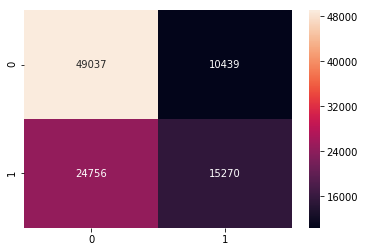

In [58]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred),
                       index=["正解 = クラウドファンディング成功","正解 = クラウドファンディング失敗"],
                       columns=["予測 = クラウドファンディング成功", "予測 = クラウドファンディング失敗"])
display(conf_mat)
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt='d')
plt.show()

今まで最も良い精度を更新した

計算時間が非常に多くかかるため、ハイパーパラメーターチューニングとクロスバリデーションは、今後の手法の結果次第とする

----
### 9.決定木

In [59]:
from sklearn.tree import DecisionTreeClassifier

In [60]:
#決定木モデルの定義
clf =  DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=3,
    random_state=1234)
#学習
clf.fit(X_tr_sc, y_train)

y_pred = clf.predict(X_te_sc)
#混合行列を作成
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
recall = 100 * (tp)/(fn+tp)
precision = 100 * (tp)/(fp+tp)
print('Accuracy = {:.3f}%'.format(accuracy))
print('Recall = {:.3f}%'.format(recall))
print('Precision = {:.3f}%'.format(precision))

Accuracy = 60.859%
Recall = 49.250%
Precision = 51.408%


,予測 = クラウドファンディング成功,予測 = クラウドファンディング失敗
正解 = クラウドファンディング成功,40843,18633
正解 = クラウドファンディング失敗,20313,19713


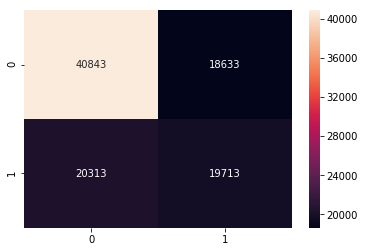

In [61]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred),
                       index=["正解 = クラウドファンディング成功","正解 = クラウドファンディング失敗"],
                       columns=["予測 = クラウドファンディング成功", "予測 = クラウドファンディング失敗"])
display(conf_mat)
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt='d')
plt.show()

精度をより上げるため、ハイパーパラメータチューニングを行っていく

In [62]:
param = {"criterion":["gini","entropy"], "splitter":["best","random"],
        "min_samples_split":[2,3],"min_samples_leaf":[2,3]}

model =  DecisionTreeClassifier(random_state=1234)

clf = GridSearchCV(model,param,cv=5)
clf.fit(X_tr_sc,y_train)
print(clf.best_params_, clf.best_score_)

{'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'random'} 0.6308523926433217


クロスバリデーションを行う

In [63]:
# 分割数n_splits, ランダム性の固定を行うrandom_state, データのシャッフルを行うかを指定するshuffleを引数に与える
n_split = 5 

kf=KFold(n_splits=n_split, random_state=1234, shuffle=True)

acc = 0
rec = 0
pre = 0
split_num = 1
# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in kf.split(x, y):
    X_train, y_train = x[train_idx], y[train_idx] #学習用データ
    X_test, y_test = x[test_idx], y[test_idx]  #テスト用データ
    
    #標準化をする
    X_tr_sc = std_scaler.fit_transform(X_train)
    X_te_sc = std_scaler.transform(X_test)
    
    #ハイパーパラメーターチューニングの結果を用いてモデルを構築する
    clf2 =  DecisionTreeClassifier(**clf.best_params_, random_state=1234)
    # 学習用データを使って学習
    clf2.fit(X_tr_sc,y_train)
    
    #クロスバリデーションの結果を算出
    y_pred = clf2.predict(X_te_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
    recall = 100 * (tp)/(fn+tp)
    precision = 100 * (tp)/(fp+tp)
    print("Fold %s"%split_num)
    print('Accuracy = {:.3f}%'.format(accuracy)) 
    print('Recall = {:.3f}%'.format(recall)) 
    print('Precision = {:.3f}%'.format(precision))
    print()

    acc += accuracy
    rec += recall
    pre += precision
    split_num +=1

final_acc = acc / n_split
final_rec = rec / n_split
final_pre = pre / n_split
print('平均 Accuracy = {:.3f}%'.format(final_acc))
print('平均 Recall = {:.3f}%'.format(final_rec))
print('平均 Precision = {:.3f}%'.format(final_pre))
    
    

Fold 1
Accuracy = 63.276%
Recall = 46.180%
Precision = 54.955%

Fold 2
Accuracy = 63.332%
Recall = 46.134%
Precision = 55.756%

Fold 3
Accuracy = 63.082%
Recall = 45.438%
Precision = 55.613%

Fold 4
Accuracy = 63.482%
Recall = 45.869%
Precision = 56.153%

Fold 5
Accuracy = 63.658%
Recall = 46.038%
Precision = 55.675%

平均 Accuracy = 63.366%
平均 Recall = 45.932%
平均 Precision = 55.630%


クロスバリデーションを行った中では、今までで最も良い精度を更新した

----
### 10.決定木 - ランダムフォレスト

In [64]:
#ランダムフォレストのモデルをインポート
from sklearn.ensemble import RandomForestClassifier
#モデルの定義
clf = RandomForestClassifier(n_estimators=20, max_depth=None, criterion="entropy",
                                                 min_samples_leaf=2, min_samples_split=3, random_state=1234)
clf.fit(X_tr_sc, y_train)

y_pred = clf.predict(X_te_sc)
#混合行列を作成
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
recall = 100 * (tp)/(fn+tp)
precision = 100 * (tp)/(fp+tp)
print('Accuracy = {:.3f}%'.format(accuracy))
print('Recall = {:.3f}%'.format(recall))
print('Precision = {:.3f}%'.format(precision))

Accuracy = 65.935%
Recall = 51.255%
Precision = 58.612%


,予測 = クラウドファンディング成功,予測 = クラウドファンディング失敗
正解 = クラウドファンディング成功,30101,9629
正解 = クラウドファンディング失敗,12968,13636


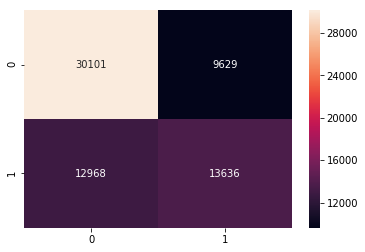

In [65]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred),
                       index=["正解 = クラウドファンディング成功","正解 = クラウドファンディング失敗"],
                       columns=["予測 = クラウドファンディング成功", "予測 = クラウドファンディング失敗"])
display(conf_mat)
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt='d')
plt.show()

ハイパーパラメータチューニングを行う

ここでは学習に時間がかかってしまうので上記の結果、ハイパーパラメータ以下の通りにし、"n_estimators"をチューニングしていく

In [66]:
#チューニングしたいハイパーパラメーター
param = {"n_estimators":[20,25,30]}

model = RandomForestClassifier( max_depth=None, criterion="entropy",
                               min_samples_leaf=2, min_samples_split=3, random_state=1234)

clf = GridSearchCV(model,param,cv=5)
clf.fit(X_tr_sc,y_train)

y_pred = clf.predict(X_te_sc)
print(clf.best_params_, clf.best_score_)

{'n_estimators': 30} 0.6594645320308437


この結果より、"n_estimators"を増やしていった方がより良い精度が出ると考えられる

そのため、一気に増やして行ってみる

In [67]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, criterion="entropy",
                                                 min_samples_leaf=2, min_samples_split=3, random_state=1234)

clf.fit(X_tr_sc, y_train)
y_pred = clf.predict(X_te_sc)
#混合行列を作成
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
recall = 100 * (tp)/(fn+tp)
precision = 100 * (tp)/(fp+tp)
print('Accuracy = {:.3f}%'.format(accuracy))
print('Recall = {:.3f}%'.format(recall))
print('Precision = {:.3f}%'.format(precision))

Accuracy = 66.471%
Recall = 51.541%
Precision = 59.460%


やはり、"n_estimators"の数を増やすと精度が上がることが分かった

クロスバリデーションを行う

In [68]:
# 分割数n_splits, ランダム性の固定を行うrandom_state, データのシャッフルを行うかを指定するshuffleを引数に与える
n_split = 5 

kf=KFold(n_splits=n_split, random_state=1234, shuffle=True)

acc = 0
rec = 0
pre = 0
split_num = 1
# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in kf.split(x, y):
    X_train, y_train = x[train_idx], y[train_idx] #学習用データ
    X_test, y_test = x[test_idx], y[test_idx]  #テスト用データ
    
    #標準化をする
    X_tr_sc = std_scaler.fit_transform(X_train)
    X_te_sc = std_scaler.transform(X_test)
    
    
    #ハイパーパラメーターチューニングの結果を用いてモデルを構築する
    clf2 = RandomForestClassifier(n_estimators=1000, max_depth=None, criterion="entropy",
                                                 min_samples_leaf=2, min_samples_split=3, random_state=1234)
    # 学習用データを使って学習
    clf2.fit(X_tr_sc,y_train)
    
    #クロスバリデーションの結果を算出
    y_pred = clf2.predict(X_te_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
    recall = 100 * (tp)/(fn+tp)
    precision = 100 * (tp)/(fp+tp)
    print("Fold %s"%split_num)
    print('Accuracy = {:.3f}%'.format(accuracy)) 
    print('Recall = {:.3f}%'.format(recall)) 
    print('Precision = {:.3f}%'.format(precision))
    print()

    acc += accuracy
    rec += recall
    pre += precision
    split_num +=1

final_acc = acc / n_split
final_rec = rec / n_split
final_pre = pre / n_split
print('平均 Accuracy = {:.3f}%'.format(final_acc))
print('平均 Recall = {:.3f}%'.format(final_rec))
print('平均 Precision = {:.3f}%'.format(final_pre))
    
    

Fold 1
Accuracy = 66.736%
Recall = 51.528%
Precision = 59.852%

Fold 2
Accuracy = 66.570%
Recall = 51.549%
Precision = 60.233%

Fold 3
Accuracy = 66.785%
Recall = 51.532%
Precision = 60.781%

Fold 4
Accuracy = 66.420%
Recall = 51.353%
Precision = 60.120%

Fold 5
Accuracy = 66.471%
Recall = 51.541%
Precision = 59.460%

平均 Accuracy = 66.596%
平均 Recall = 51.501%
平均 Precision = 60.089%


前回に引き続き最も良い精度を更新した

----
### 11.決定木 - アダブースト

In [69]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [70]:
#モデルの定義
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, criterion="entropy",
                                                 min_samples_leaf=2, min_samples_split=3),
                         random_state=1234, n_estimators=10)
clf.fit(X_tr_sc, y_train)

y_pred = clf.predict(X_te_sc)
#混合行列を作成
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
recall = 100 * (tp)/(fn+tp)
precision = 100 * (tp)/(fp+tp)
print('Accuracy = {:.3f}%'.format(accuracy))
print('Recall = {:.3f}%'.format(recall))
print('Precision = {:.3f}%'.format(precision))

Accuracy = 67.643%
Recall = 53.458%
Precision = 61.028%


,予測 = クラウドファンディング成功,予測 = クラウドファンディング失敗
正解 = クラウドファンディング成功,30648,9082
正解 = クラウドファンディング失敗,12382,14222


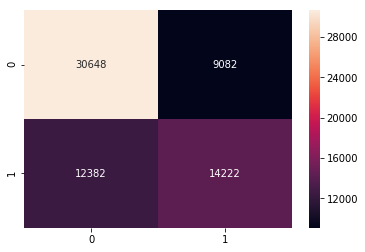

In [71]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred),
                       index=["正解 = クラウドファンディング成功","正解 = クラウドファンディング失敗"],
                       columns=["予測 = クラウドファンディング成功", "予測 = クラウドファンディング失敗"])
display(conf_mat)
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt='d')
plt.show()

ハイパーパラメータチューニングを行う

In [72]:
param = {"n_estimators":[5,10,15,30]}

model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, criterion="entropy",
                                                 min_samples_leaf=2, min_samples_split=3),
                         random_state=1234)

clf = GridSearchCV(model,param,cv=5)
clf.fit(X_tr_sc,y_train)
print(clf.best_params_, clf.best_score_)

{'n_estimators': 5} 0.6731941900519337


In [73]:
# 分割数n_splits, ランダム性の固定を行うrandom_state, データのシャッフルを行うかを指定するshuffleを引数に与える
n_split = 5 

kf=KFold(n_splits=n_split, random_state=1234, shuffle=True)

acc = 0
rec = 0
pre = 0
split_num = 1
# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in kf.split(x, y):
    X_train, y_train = x[train_idx], y[train_idx] #学習用データ
    X_test, y_test = x[test_idx], y[test_idx]  #テスト用データ
    
    #標準化をする
    X_tr_sc = std_scaler.fit_transform(X_train)
    X_te_sc = std_scaler.transform(X_test)
    #ハイパーパラメーターチューニングの結果を使用
    clf2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, criterion="entropy",
                                                 min_samples_leaf=2, min_samples_split=3),
                         random_state=1234, n_estimators=5) 
    # 学習用データを使って線形回帰モデルを学習
    clf2.fit(X_tr_sc,y_train)
    
   #クロスバリデーションの結果を算出
    y_pred = clf2.predict(X_te_sc)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
    recall = 100 * (tp)/(fn+tp)
    precision = 100 * (tp)/(fp+tp)
    print("Fold %s"%split_num)
    print('Accuracy = {:.3f}%'.format(accuracy)) 
    print('Recall = {:.3f}%'.format(recall)) 
    print('Precision = {:.3f}%'.format(precision))
    print()

    acc += accuracy
    rec += recall
    pre += precision
    split_num +=1

final_acc = acc / n_split
final_rec = rec / n_split
final_pre = pre / n_split
print('平均 Accuracy = {:.3f}%'.format(final_acc))
print('平均 Recall = {:.3f}%'.format(final_rec))
print('平均 Precision = {:.3f}%'.format(final_pre))
    

Fold 1
Accuracy = 67.587%
Recall = 52.269%
Precision = 61.171%

Fold 2
Accuracy = 67.230%
Recall = 51.947%
Precision = 61.295%

Fold 3
Accuracy = 67.433%
Recall = 51.528%
Precision = 61.948%

Fold 4
Accuracy = 67.362%
Recall = 52.909%
Precision = 61.373%

Fold 5
Accuracy = 67.615%
Recall = 52.973%
Precision = 61.104%

平均 Accuracy = 67.446%
平均 Recall = 52.325%
平均 Precision = 61.378%


ランダムフォレストより更に、精度が向上した

----
### 12.ニューラルネットワーク

In [74]:
#無相関化したデータを用いる
y = df_csv["state"].values
x = df_csv.drop(columns=["state"]).values
test_size = 0.3
#学習用データ、テスト用データに分割する
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
#正解クラスをone-hotエンコーディング
from tensorflow.keras.utils import to_categorical
y_train_encode = to_categorical(y_train)
y_test_encode = to_categorical(y_test)

In [75]:
#改めて訓練データ、テストデータを確認する
print(X_train.shape)
print()
print(X_test.shape)
print()
print(y_train.shape)
print()
print(y_test.shape)

(232170, 7)

(99502, 7)

(232170,)

(99502,)


In [76]:
#必要なライブラリをインポート
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

#学習率、エポックを定める
batch_size = 40
epochs = 30

#modelを構築する
#活性化関数にreluを用いる
model = Sequential()
model.add(Dense(26, activation='relu', input_shape=(7,)))
model.add(Dense(26, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(2, activation='softmax'))

#今回はAdamを用いる
# ------ 最適化手法 ------
#sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

#modelをコンパイラする
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [78]:
#学習
fit = model.fit(X_train, y_train_encode,epochs=epochs,batch_size=batch_size,
               validation_data=(X_test, y_test_encode))

Train on 232170 samples, validate on 99502 samples
Epoch 1/30
232170/232170 [==============================] - 5s 22us/sample - loss: 0.6746 - acc: 0.5971 - val_loss: 0.6754 - val_acc: 0.5939
Epoch 2/30
232170/232170 [==============================] - 5s 22us/sample - loss: 0.6745 - acc: 0.5971 - val_loss: 0.6762 - val_acc: 0.5939
Epoch 3/30
232170/232170 [==============================] - 5s 21us/sample - loss: 0.6746 - acc: 0.5971 - val_loss: 0.6754 - val_acc: 0.5939
Epoch 4/30
232170/232170 [==============================] - 5s 22us/sample - loss: 0.6746 - acc: 0.5971 - val_loss: 0.6755 - val_acc: 0.5939
Epoch 5/30
232170/232170 [==============================] - 5s 21us/sample - loss: 0.6745 - acc: 0.5971 - val_loss: 0.6763 - val_acc: 0.5939
Epoch 6/30
232170/232170 [==============================] - 5s 21us/sample - loss: 0.6745 - acc: 0.5971 - val_loss: 0.6758 - val_acc: 0.5939
Epoch 7/30
232170/232170 [==============================] - 5s 21us/sample - loss: 0.6746 - acc: 0.5971

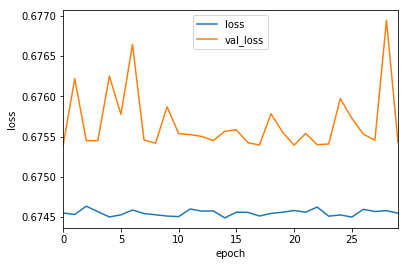

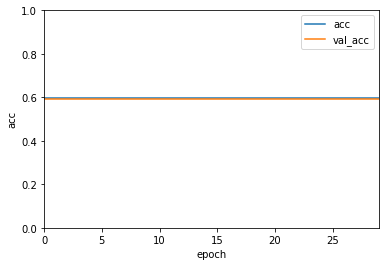

In [79]:
#loss関数とaccuracyをDataFrameにまとめる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [80]:
y_pred = np.argmax(model.predict(X_test),axis=1)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
recall = 100 * (tp)/(fn+tp)
precision = 100 * (tp)/(fp+tp)
print('Accuracy = {:.3f}%'.format(accuracy))
print('Recall = {:.3f}%'.format(recall))
print('Precision = {:.3f}%'.format(precision))

Accuracy = 59.394%
Recall = 0.000%
Precision = nan%


C:\Users\progr\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in longlong_scalars
  """


学習回数は精度に関係がないことが確認できる

更に、精度もあまりよくないことから、現段階の知識では最適な手段とは判断できない

----
### 11.ニューラルネットワーク - 標準化

In [81]:
#無相関化したデータを用いる
y = df_csv["state"].values
x = df_csv.drop(columns=["state"]).values
test_size = 0.3
#学習用データ、テスト用データに分割する
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

#標準化をする
X_tr_sc = std_scaler.fit_transform(X_train)
X_te_sc = std_scaler.transform(X_test)
#正解クラスをone-hotエンコーディング
y_train_encode = to_categorical(y_train)
y_test_encode = to_categorical(y_test)


In [82]:
#学習率、エポックを定める
batch_size = 40
epochs = 30

#今回は活性化関数にreluを用い、学習を試みる
#全結合型
#出力時にsigmoid関数を用いる
model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(7,)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(2,activation="softmax"))

#最適化手法にAdamを使用する
# ------ 最適化手法 ------
#sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [83]:
#学習
fit = model.fit(X_tr_sc, y_train_encode,epochs=epochs,batch_size=batch_size,
                validation_data=(X_te_sc, y_test_encode))

Train on 232170 samples, validate on 99502 samples
Epoch 1/30
232170/232170 [==============================] - 5s 22us/sample - loss: 0.6476 - acc: 0.6155 - val_loss: 0.6325 - val_acc: 0.6419
Epoch 2/30
232170/232170 [==============================] - 5s 22us/sample - loss: 0.6335 - acc: 0.6354 - val_loss: 0.6277 - val_acc: 0.6421
Epoch 3/30
232170/232170 [==============================] - 5s 21us/sample - loss: 0.6308 - acc: 0.6364 - val_loss: 0.6295 - val_acc: 0.6427
Epoch 4/30
232170/232170 [==============================] - 5s 21us/sample - loss: 0.6292 - acc: 0.6392 - val_loss: 0.6265 - val_acc: 0.6408
Epoch 5/30
232170/232170 [==============================] - 5s 22us/sample - loss: 0.6279 - acc: 0.6402 - val_loss: 0.6226 - val_acc: 0.6474
Epoch 6/30
232170/232170 [==============================] - 5s 22us/sample - loss: 0.6267 - acc: 0.6417 - val_loss: 0.6247 - val_acc: 0.6388
Epoch 7/30
232170/232170 [==============================] - 5s 21us/sample - loss: 0.6259 - acc: 0.6441

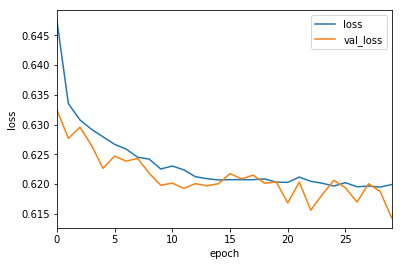

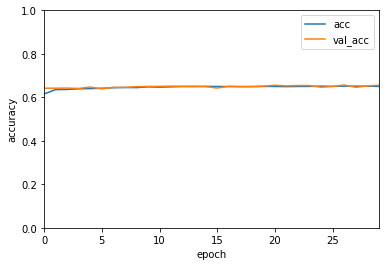

In [84]:
#loss関数とaccuracyをDataFrameにまとめる
df = pd.DataFrame(fit.history)
# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [85]:
y_pred = np.argmax(model.predict(X_te_sc),axis=1)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
recall = 100 * (tp)/(fn+tp)
precision = 100 * (tp)/(fp+tp)
print('Accuracy = {:.3f}%'.format(accuracy))
print('Recall = {:.3f}%'.format(recall))
print('Precision = {:.3f}%'.format(precision))

Accuracy = 65.584%
Recall = 43.023%
Precision = 59.983%


やはり、精度は上昇したものの、今回では最適な手段と判断できない

----
### 12.ニューラルネットワーク - 標準化 - Dropout法

In [86]:
#学習率、エポックを定める
batch_size = 40
epochs = 20

#今回は活性化関数にreluを用い、dropout法を用いる
model = Sequential()
model.add(Dense(units=40, activation='relu', input_shape=(7,)))
model.add(Dropout(0.1)) 
model.add(Dense(units=40, activation='relu'))
model.add(Dropout(0.1)) 
model.add(Dense(units=20, activation='relu'))
model.add(Dropout(0.1)) 
model.add(Dense(2,activation='softmax'))

#最適化手法にAdamを使用する
# ------ 最適化手法 ------
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [87]:
#学習
fit = model.fit(X_tr_sc, y_train_encode,epochs=epochs,batch_size=batch_size,
                validation_data=(X_te_sc, y_test_encode))

Train on 232170 samples, validate on 99502 samples
Epoch 1/20
232170/232170 [==============================] - 7s 29us/sample - loss: 0.6545 - acc: 0.6055 - val_loss: 0.6412 - val_acc: 0.6093
Epoch 2/20
232170/232170 [==============================] - 7s 29us/sample - loss: 0.6457 - acc: 0.6171 - val_loss: 0.6396 - val_acc: 0.6324
Epoch 3/20
232170/232170 [==============================] - 7s 29us/sample - loss: 0.6481 - acc: 0.6198 - val_loss: 0.6353 - val_acc: 0.6401
Epoch 4/20
232170/232170 [==============================] - 7s 28us/sample - loss: 0.6427 - acc: 0.6233 - val_loss: 0.6425 - val_acc: 0.6305
Epoch 5/20
232170/232170 [==============================] - 7s 28us/sample - loss: 0.6417 - acc: 0.6253 - val_loss: 0.6303 - val_acc: 0.6320
Epoch 6/20
232170/232170 [==============================] - 7s 28us/sample - loss: 0.6410 - acc: 0.6247 - val_loss: 0.6294 - val_acc: 0.6353
Epoch 7/20
232170/232170 [==============================] - 7s 29us/sample - loss: 0.6408 - acc: 0.6250

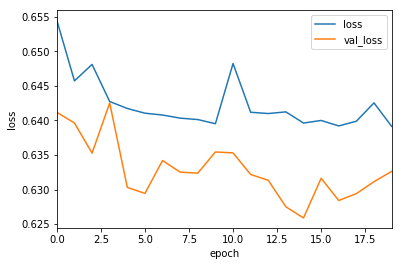

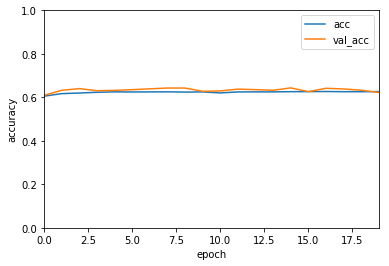

In [88]:
#loss関数とaccuracyをDataFrameにまとめる
df = pd.DataFrame(fit.history)
# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [89]:
y_pred = np.argmax(model.predict(X_te_sc),axis=1)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
recall = 100 * (tp)/(fn+tp)
precision = 100 * (tp)/(fp+tp)
print('Accuracy = {:.3f}%'.format(accuracy))
print('Recall = {:.3f}%'.format(recall))
print('Precision = {:.3f}%'.format(precision))

Accuracy = 62.250%
Recall = 14.952%
Precision = 62.609%


lossがepoch20の付近で上昇しているため増やして学習させる

In [90]:
epochs = 45
#学習
fit = model.fit(X_tr_sc, y_train_encode,epochs=epochs,batch_size=batch_size,
                validation_data=(X_te_sc, y_test_encode))

Train on 232170 samples, validate on 99502 samples
Epoch 1/45
232170/232170 [==============================] - 7s 28us/sample - loss: 0.6387 - acc: 0.6276 - val_loss: 0.6274 - val_acc: 0.6434
Epoch 2/45
232170/232170 [==============================] - 6s 28us/sample - loss: 0.6386 - acc: 0.6270 - val_loss: 0.6265 - val_acc: 0.6381
Epoch 3/45
232170/232170 [==============================] - 6s 27us/sample - loss: 0.6395 - acc: 0.6275 - val_loss: 0.6275 - val_acc: 0.6407
Epoch 4/45
232170/232170 [==============================] - 7s 29us/sample - loss: 0.6386 - acc: 0.6273 - val_loss: 0.6306 - val_acc: 0.6307
Epoch 5/45
232170/232170 [==============================] - 7s 29us/sample - loss: 0.6390 - acc: 0.6271 - val_loss: 0.6261 - val_acc: 0.6464
Epoch 6/45
232170/232170 [==============================] - 7s 30us/sample - loss: 0.6386 - acc: 0.6280 - val_loss: 0.6286 - val_acc: 0.6402
Epoch 7/45
232170/232170 [==============================] - 7s 29us/sample - loss: 0.6383 - acc: 0.6272

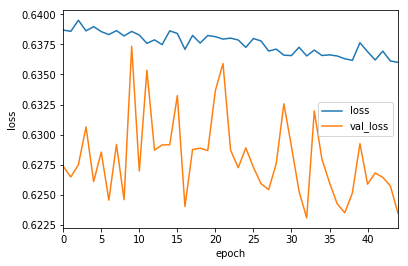

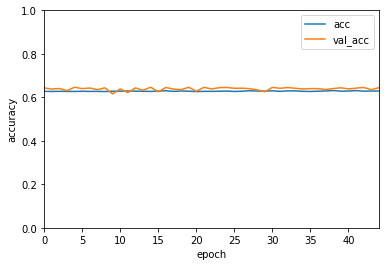

In [91]:
#loss関数とaccuracyをDataFrameにまとめる
df = pd.DataFrame(fit.history)
# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [92]:
y_pred = np.argmax(model.predict(X_te_sc),axis=1)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = 100 * (tn+tp)/(tn+fp+fn+tp)
recall = 100 * (tp)/(fn+tp)
precision = 100 * (tp)/(fp+tp)
print('Accuracy = {:.3f}%'.format(accuracy))
print('Recall = {:.3f}%'.format(recall))
print('Precision = {:.3f}%'.format(precision))

Accuracy = 64.465%
Recall = 32.946%
Precision = 60.612%


-----------
### まとめ

#### 今回の最適な結果
* 説明変数 : "day","usd_goal_real","country","goal","currency","main_category","category","name"
* 前処理 : 標準化
* モデル : AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, criterion="entropy", min_samples_leaf=2, min_samples_split=3),random_state=1234, n_estimators=5) 

#### 精度結果
* Accuracy : 67.446%
* Recall : 52.325%
* precision : 61.378%




今回はディープラーニングの知識があまりないため深く掘り下げることはできなかったが、決定木でもSVMと同等な精度かそれ以上の結果が得られた

最後にクラウドファンディングの目標金額を集めるためには時代の流行や、プロジェクト開始から5日の達成率やPRの仕方などを説明変数として扱うことが出来れば精度は向上するのではないだろうかと感じた